In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
plt.rcParams['figure.dpi']=200
plt.rcParams['font.size']=16
plt.rcParams['legend.fontsize']='small'
plt.rcParams['xtick.labelsize']='small'
plt.rcParams['ytick.labelsize']='small'
plt.rcParams['mathtext.fontset']='cm'

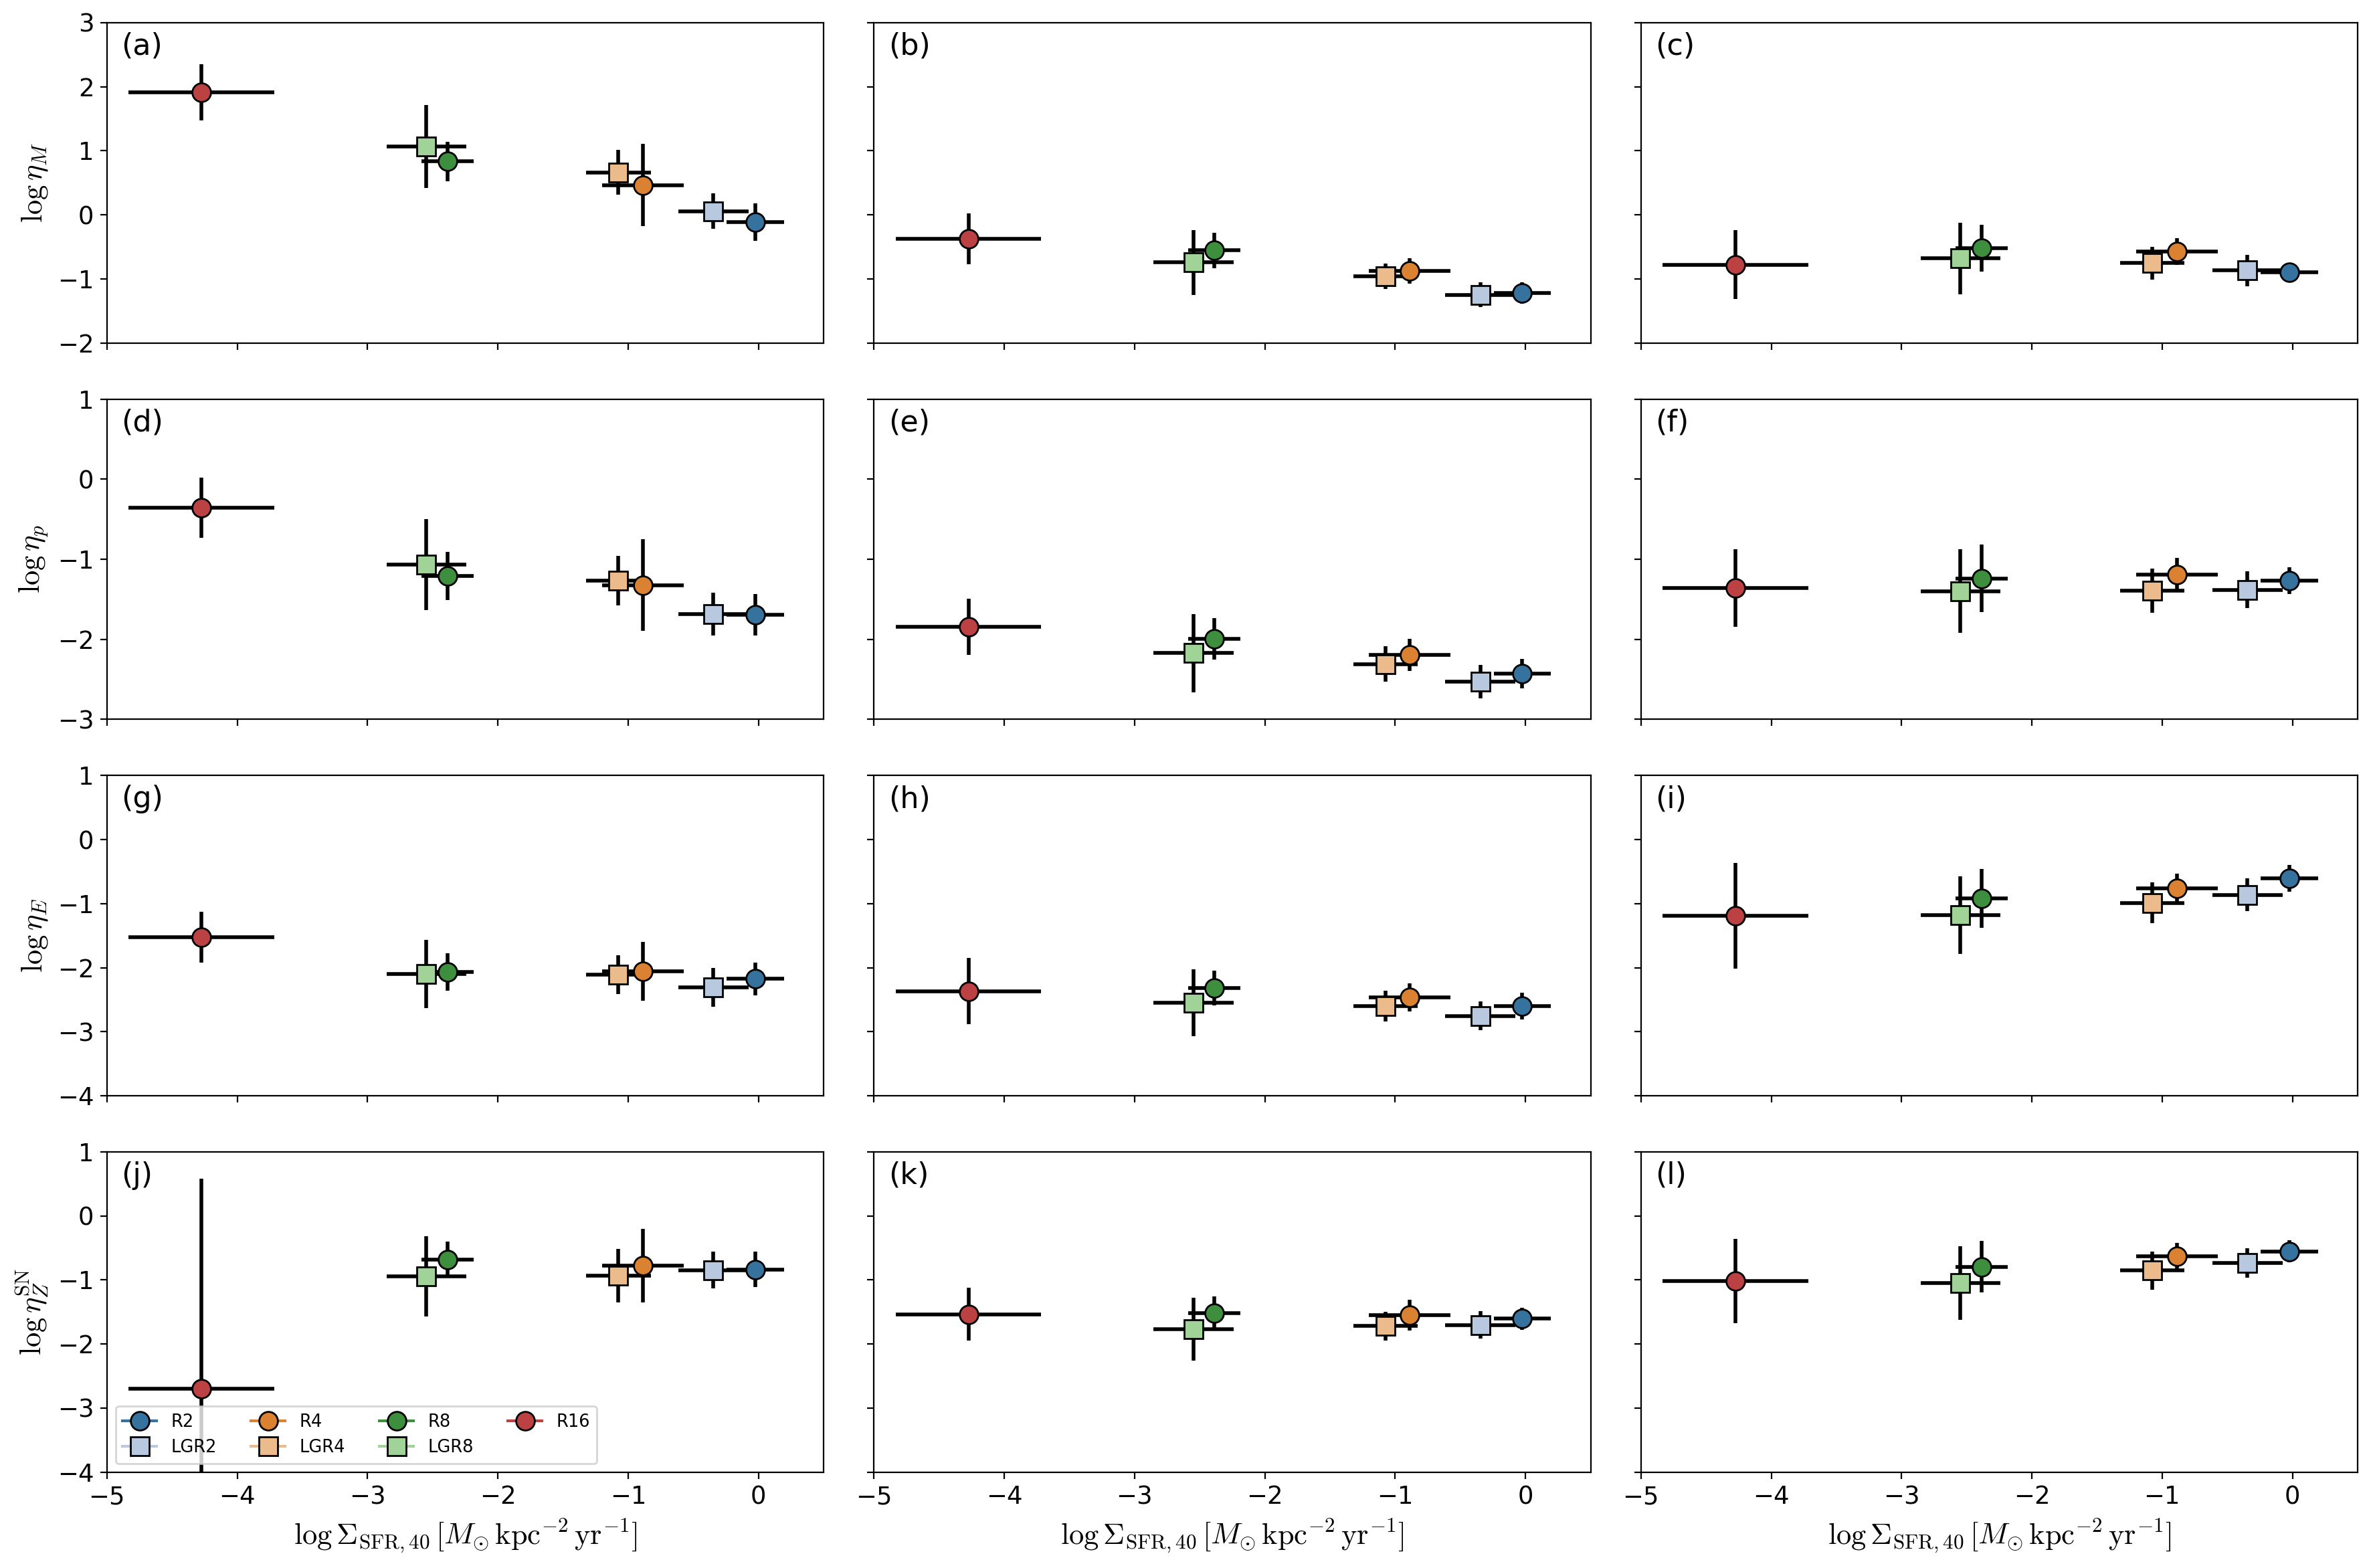

In [7]:
# Reading Tables with astropy:

from astropy.table import QTable,Table
tmean=Table.read('../paper-tables/table-mean.ecsv')
tstd=Table.read('../paper-tables/table-std.ecsv')

# Reproducing Figure 6 including (intermediate phase):
colors=[(0.20921568627450982, 0.45078431372549005, 0.6182352941176471),
         (0.7164705882352944, 0.7850980392156864, 0.8756862745098037),
         (0.8582352941176472, 0.5068627450980392, 0.19666666666666655),
         (0.9205882352941176, 0.733921568627451, 0.5500000000000002),
         (0.24078431372549025, 0.5592156862745098, 0.24078431372549025),
         (0.6296078431372548, 0.8245098039215686, 0.5911764705882352),
         (0.7362745098039216, 0.25588235294117645, 0.2586274509803921)]
markers=['o', 's', 'o', 's', 'o', 's', 'o']
names=['R2', 'LGR2', 'R4', 'LGR4', 'R8', 'LGR8', 'R16']

yfields=['mass_loading','mom_loading','energy_loading','metal_sn_loading']
labels=[r'$\eta_M$',r'$\eta_p$',r'$\eta_E$',r'$\eta_Z^{\rm SN}$']
phases=['cool','int','hot']

Nrows=len(yfields)
Ncols=len(phases)
z = 'H'
xfield = 'sfr40'
xlabel=r'$\Sigma_{{\rm SFR,40}}\,[M_{\odot}{\rm \, kpc^{-2}\,yr^{-1}}]$'

fig, axes = plt.subplots(Nrows,Ncols,figsize=(6*Ncols,3*Nrows),
                         sharex='col',sharey='row',squeeze=False)

for i,field in enumerate(yfields):
    for j,ph in enumerate(phases):
        plt.sca(axes[i,j])
        for name,c,m in zip(names,colors,markers):
            idx=(tmean['phase'] == ph) & (tmean['z'] == z) & (tmean['model'] == name)
            xmean = tmean[idx][xfield]
            ymean = tmean[idx][field]
            xstd = tstd[idx][xfield]
            ystd = tstd[idx][field]
            xlogstd= xstd/xmean/np.log(10)
            ylogstd= ystd/ymean/np.log(10)
            plt.errorbar(np.log10(xmean),np.log10(ymean),
                         xerr=xlogstd,yerr=ylogstd,
                         color=c,marker=m,label=name,
                         elinewidth=2,ecolor='k',markersize=10.0,
                         markeredgecolor='k',markeredgewidth=1,
                        )
        
# Decorating axes
axes[-1,0].legend(fontsize='xx-small',ncol=4,loc='lower left')
plt.setp(axes,'xlim',(-5,0.5))
axes[0,0].set_ylim(-2,3)
axes[1,0].set_ylim(-3,1)
axes[2,0].set_ylim(-4,1)
axes[3,0].set_ylim(-4,1)
for ax,lab in zip(axes.flat,'abcdefghijklmnopqrstuvwxyz'):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.annotate('({})'.format(lab),[0.02,0.90],xycoords='axes fraction')

for ax,lab in zip(axes[:,0],labels):
    ax.set_ylabel(r'$\log\,$'+lab)
plt.setp(axes[-1,:],'xlabel',r'$\log\,$'+xlabel)
plt.tight_layout()